# Tests for the lights module

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import numpy as np
from fastcore.test import *
from circadian.lights import LightSchedule

In [ ]:
# test LightSchedule's init
test_eq(LightSchedule(1.0)._func(0.0), 1.0)
test_eq(LightSchedule(1)._func(0.0), 1.0)
test_eq(LightSchedule(lambda t: t)._func(0.0), 0.0)
test_eq(LightSchedule(lambda t: 2*t)._func(10.0), 20.0)
test_eq(LightSchedule(lambda t: t)._func([0.0, 1.0, 2.0]), [0.0, 1.0, 2.0])
test_eq(LightSchedule(lambda t: t)._func(np.array([0.0, 1.0, 2.0])), np.array([0.0, 1.0, 2.0]))
# test periodic light schedules
test_eq(LightSchedule(lambda t: t, period=24.0)._func(0.0), 0.0)
test_eq(LightSchedule(lambda t: t, period=24.0)._func(25.0), 1.0)
# test error handling for light
light_input_err_msg = "`light` should be a `float`, or a callable with a single `float` parameter which returns `float`"
test_fail(lambda: LightSchedule('a'), msg=light_input_err_msg)
test_fail(lambda: LightSchedule([]), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x: 'a'), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x: []), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(lambda x, y: 1.0), msg=light_input_err_msg)
test_fail(lambda: LightSchedule(-1.0), msg=light_input_err_msg)
# test error handling for period
period_err_msg = "`period` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule(lambda t: t, period='a'), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=[]), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=lambda t: t), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=-1.0), msg=period_err_msg)
test_fail(lambda: LightSchedule(lambda t: t, period=0.0), msg=period_err_msg)

In [ ]:
# test LightSchedule's call
test_eq(LightSchedule(1.0)(0.0), 1.0)
test_eq(LightSchedule(1.0)([0.0, 1.0, 2.0]), [1.0, 1.0, 1.0])
test_eq(LightSchedule(1.0)(np.array([0.0, 1.0, 2.0])), np.array([1.0, 1.0, 1.0]))
test_eq(LightSchedule(lambda t: t)(0.0), 0.0)
test_eq(LightSchedule(lambda t: t)([0.0, 1.0, 2.0]), [0.0, 1.0, 2.0])
test_eq(LightSchedule(lambda t: t)(np.array([0.0, 1.0, 2.0])), np.array([0.0, 1.0, 2.0]))
test_eq(LightSchedule(lambda t: 2*t)(10.0), 20.0)
test_eq(LightSchedule(lambda t: 2*t)([0.0, 1.0, 2.0]), [0.0, 2.0, 4.0])
# test periodic light schedules
test_eq(LightSchedule(lambda t: t, period=24.0)(0.0), 0.0)
test_eq(LightSchedule(lambda t: t, period=24.0)(25.0), 1.0)
# test error handling
time_err_msg = "`time` should be a `float` or a 1d `numpy.ndarray` of `float`"
test_fail(lambda: LightSchedule(1.0)('a'), msg=time_err_msg)
test_fail(lambda: LightSchedule(1.0)(np.zeros((2,2))), msg=time_err_msg)
# test passing an object that can't be converted to numpy array
test_fail(lambda: LightSchedule(1.0)(object()), msg=time_err_msg)
# test warning of negative light values
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    LightSchedule(lambda t: -1.0)(0.0)
    assert len(w) == 1
    assert issubclass(w[-1].category, UserWarning)
    assert "Some light values are negative" in str(w[-1].message)

In [ ]:
# test LightSchedule.from_pulse
def ground_truth_schedule(time):
    if time < 1.0 or time > 3.0:
        return 0.0
    else:
        return 100.0
ground_truth_schedule = np.vectorize(ground_truth_schedule, otypes=[float])
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0)
time = np.linspace(0.0, 48.0, 1000)
test_eq(schedule(time), ground_truth_schedule(time))
# test repetitive pulse
def ground_truth_repetitive_schedule(time):
    t = np.mod(time, 24.0)
    if t < 1.0 or t > 3.0:
        return 0.0
    else:
        return 100.0
ground_truth_repetitive_schedule = np.vectorize(ground_truth_repetitive_schedule, otypes=[float])
repetitive_schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
time = np.linspace(0.0, 48.0, 1000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_schedule(time))
# test error handling
lux_err_msg = "`lux` should be a nonnegative `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(-1.0, 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse('a', 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse([], 1.0, 2.0), msg=lux_err_msg)
test_fail(lambda: LightSchedule.from_pulse(lambda t: t, 1.0, 2.0), msg=lux_err_msg)
start_err_msg = "`start` should be a `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 'a', 2.0), msg=start_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, [], 2.0), msg=start_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, lambda t: t, 2.0), msg=start_err_msg)
duration_err_msg = "`duration` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 0.0), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, -2.0), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 'a'), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, []), msg=duration_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, lambda t: t), msg=duration_err_msg)
period_err_msg = "`period` should be a positive `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, 0.0), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, -2.0), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, 'a'), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, []), msg=period_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, lambda t: t), msg=period_err_msg)
baseline_err_msg = "`baseline` should be a nonnegative `float` or `int`"
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=-1.0), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline='a'), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=[]), msg=baseline_err_msg)
test_fail(lambda: LightSchedule.from_pulse(100.0, 1.0, 2.0, baseline=lambda t: t), msg=baseline_err_msg)

In [ ]:
# test LightSchedule's add
time = np.linspace(0.0, 48.0, 1000)
constant_1 = LightSchedule(1.0)
constant_2 = LightSchedule(2.0)
test_eq((constant_1 + constant_2)(time), 3.0*np.ones_like(time))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_combined(time):
    if time < 1.0:
        return 0.0
    elif time >= 1.0 and time < 3.0:
        return 100.0
    elif time >= 3.0 and time < 5.0:
        return 0.0
    elif time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_combined = np.vectorize(ground_truth_pulses_combined, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0)
schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0)
schedule = schedule_1 + schedule_2
time = np.linspace(0.0, 48.0, 1000)
test_eq(schedule(time), ground_truth_pulses_combined(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_combined(time):
    t = np.mod(time, 13.0) 
    if t < 1.0:
        return 0.0
    elif t >= 1.0 and t < 3.0:
        return 100.0
    elif t >= 3.0 and t < 5.0:
        return 0.0
    elif t >= 5.0 and t < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_repetitive_pulses_combined = np.vectorize(ground_truth_repetitive_pulses_combined, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0, 13.0)
repetitive_schedule = repetitive_schedule_1 + repetitive_schedule_2
time = np.linspace(0.0, 150.0, 1000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_combined(time))
# TODO: fix edge case when the two schedules match at a single point
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0) + 1.0, msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0) + [], msg=schedule_err_msg)

In [ ]:
# test LightSchedule's sub
time = np.linspace(0.0, 48.0, 1000)
constant_1 = LightSchedule(10.0)
constant_2 = LightSchedule(3.0)
test_eq((constant_1 - constant_2)(time), 7.0*np.ones_like(time))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_subtract(time):
    if time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_subtract = np.vectorize(ground_truth_pulses_subtract, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 5.0, 5.0)
schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0)
schedule = schedule_1 - schedule_2
test_eq(schedule(time), ground_truth_pulses_subtract(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_subtract(time):
    t = np.mod(time, 13.0) 
    if t >= 5.0 and t < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_repetitive_pulses_subtract = np.vectorize(ground_truth_repetitive_pulses_subtract, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 5.0, 5.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 5.0, 5.0, 13.0)
repetitive_schedule = repetitive_schedule_1 - repetitive_schedule_2
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_subtract(time))
# TODO: fix edge case when the two schedules match at a single point
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0) - 1.0, msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0) - [], msg=schedule_err_msg)

In [ ]:
# test LightSchedule's concatenate_at
time = np.linspace(0.0, 48.0, 1000)
timepoint = 24.0
constant_1 = LightSchedule(1.0)
constant_2 = LightSchedule(2.0)
ground_truth_before = np.ones_like(time[time < timepoint])
ground_truth_after = 2.0*np.ones_like(time[time >= timepoint])
test_eq(constant_1.concatenate_at(constant_2, timepoint)(time), np.concatenate((ground_truth_before, ground_truth_after)))
# test combining two pulse schedules that don't repeat
def ground_truth_pulses_concatenate(time):
    if time < 1.0:
        return 0.0
    elif time >= 1.0 and time < 3.0:
        return 100.0
    elif time >= 3.0 and time < 5.0:
        return 0.0
    elif time >= 5.0 and time < 10.0:
        return 50.0
    else:
        return 0.0

ground_truth_pulses_concatenate = np.vectorize(ground_truth_pulses_concatenate, otypes=[float])
schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0)
schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 5.0)
schedule = schedule_1.concatenate_at(schedule_2, 3.0)
test_eq(schedule(time), ground_truth_pulses_concatenate(time))
# same schedule but built from constant portions
constant_1 = LightSchedule(0.0)
constant_2 = LightSchedule(100.0)
constant_3 = LightSchedule(50.0)
schedule_const = constant_1.concatenate_at(constant_2, 1.0)
schedule_const = schedule_const.concatenate_at(constant_1, 3.0)
schedule_const = schedule_const.concatenate_at(constant_3, 5.0)
schedule_const = schedule_const.concatenate_at(constant_1, 10.0)
test_eq(schedule_const(time), ground_truth_pulses_concatenate(time))
# test combining two repetitive pulses
def ground_truth_repetitive_pulses_concatenate(time):
    if time < 13*4 + 2:
        t = np.mod(time, 13.0) 
        if t < 1.0:
            return 0.0
        elif t >= 1.0 and t < 3.0:
            return 100.0
        else:
            return 0.0
    else:
        t = np.mod(time - 2, 26.0) # note the shift in time
        if t < 1.0:
            return 0.0
        elif t >= 2.0 and t < 5.0:
            return 50.0
        else:
            return 0.0

ground_truth_repetitive_pulses_concatenate = np.vectorize(ground_truth_repetitive_pulses_concatenate, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 3.0, 26.0)
repetitive_schedule = repetitive_schedule_1.concatenate_at(repetitive_schedule_2, 13*4 + 2)
time = np.linspace(0.0, 13*4 + 26*4, 5000)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_concatenate(time))
# test combining two repetitive pulses with shift_schedule=False
def ground_truth_repetitive_pulses_concatenate_no_shift(time):
    if time < 13*4:
        t = np.mod(time, 13.0) 
        if t < 1.0:
            return 0.0
        elif t >= 1.0 and t < 3.0:
            return 100.0
        else:
            return 0.0
    else:
        t = np.mod(time, 26.0) 
        if t < 1.0:
            return 0.0
        elif t >= 2.0 and t < 5.0:
            return 50.0
        else:
            return 0.0

ground_truth_repetitive_pulses_concatenate_no_shift = np.vectorize(ground_truth_repetitive_pulses_concatenate_no_shift, otypes=[float])
repetitive_schedule_1 = LightSchedule.from_pulse(100.0, 1.0, 2.0, 13.0)
repetitive_schedule_2 = LightSchedule.from_pulse(50.0, 2.0, 3.0, 26.0)
repetitive_schedule = repetitive_schedule_1.concatenate_at(repetitive_schedule_2, 13*4, shift_schedule=False)
test_eq(repetitive_schedule(time), ground_truth_repetitive_pulses_concatenate_no_shift(time))
# test error handling
schedule_err_msg = "`schedule` should be a `LightSchedule` object"
test_fail(lambda: LightSchedule(1.0).concatenate_at(1.0, 1.0), msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at([], 1.0), msg=schedule_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(lambda t: t, 1.0), msg=schedule_err_msg)
timepoint_err_msg = "`timepoint` should be a `float` or `int`"
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), 'a'), msg=timepoint_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), []), msg=timepoint_err_msg)
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), lambda t: t), msg=timepoint_err_msg)
shift_schedule_err_msg = "`shift_schedule` should be a `bool`"
test_fail(lambda: LightSchedule(1.0).concatenate_at(LightSchedule(1.0), 1.0, shift_schedule='a'), msg=shift_schedule_err_msg)

In [ ]:
# Tests: Plot type checking
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
test_fail(lambda: schedule.plot("a", 1), contains="plot_start_time must be a float or int")
test_fail(lambda: schedule.plot(0, "a"), contains="plot_end_time must be a float or int")
test_fail(lambda: schedule.plot(0, 1, num_samples="a"), contains="num_samples must be an int")
test_fail(lambda: schedule.plot(0, 1, ax="a"), contains="ax must be a matplotlib Axes object")

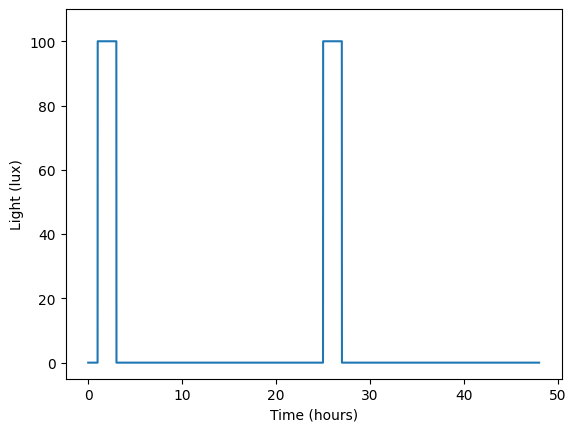

In [ ]:
schedule = LightSchedule.from_pulse(100.0, 1.0, 2.0, 24.0)
ax = schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 110);

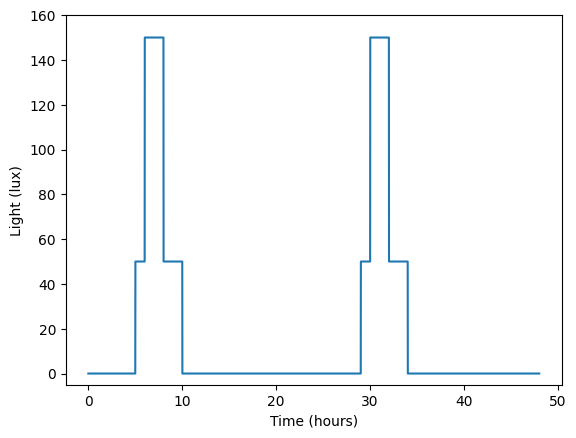

In [ ]:
sum_schedule = LightSchedule.from_pulse(100.0, 6.0, 2.0, 24.0) + LightSchedule.from_pulse(50.0, 5.0, 5.0, 24.0)
ax = sum_schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 160);

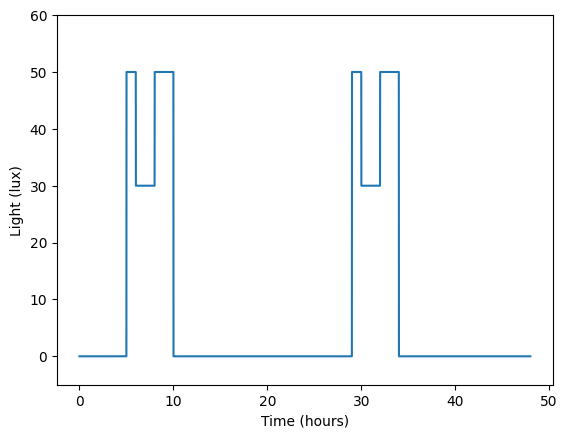

In [ ]:
sum_schedule = LightSchedule.from_pulse(50.0, 5.0, 5.0, 24.0) - LightSchedule.from_pulse(20.0, 6.0, 2.0, 24.0)
ax = sum_schedule.plot(0.0, 48.0)
ax.set_xlabel('Time (hours)');
ax.set_ylabel('Light (lux)');
ax.set_ylim(-5, 60);

In [ ]:
# test Regular
time = np.linspace(0.0, 48.0, 1000)
# correct creation of standard Regular
regular_light = LightSchedule.Regular()
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 23.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 23.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of Regular with custom lux
regular_light = LightSchedule.Regular(lux=100.0)
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 23.0)]) == 100.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 23.0 + 24.0)]) == 100.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of Regular with custom lights_on
regular_light = LightSchedule.Regular(lights_on=6.0)
test_eq(np.all(regular_light(time[time < 6.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0) & (time <= 23.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 6.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0 + 24.0) & (time <= 23.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 23.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of Regular with custom lights_off
regular_light = LightSchedule.Regular(lights_off=18.0)
test_eq(np.all(regular_light(time[time < 7.0]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0) & (time <= 18.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 18.0) & (time < 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 7.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time >= 7.0 + 24.0) & (time <= 18.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time > 18.0 + 24.0) & (time < 24.0 + 24.0)]) == 0.0), True)
# correct creation of Regular with custom lights_on > lights_off
regular_light = LightSchedule.Regular(lights_on=18.0, lights_off=6.0)
test_eq(np.all(regular_light(time[time < 6.0]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0) & (time <= 18.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time > 18.0) & (time < 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 24.0) & (time < 6.0 + 24.0)]) == 150.0), True)
test_eq(np.all(regular_light(time[(time >= 6.0 + 24.0) & (time <= 18.0 + 24.0)]) == 0.0), True)
test_eq(np.all(regular_light(time[(time > 18.0 + 24.0) & (time < 24.0 + 24.0)]) == 150.0), True)
# Tests: Type checking
test_fail(lambda: LightSchedule.Regular(lux='a'), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Regular(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Regular(lights_on='a'), contains="lights_on must be a float or int")
test_fail(lambda: LightSchedule.Regular(lights_on=-1.0), contains="lights_on must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.Regular(lights_on=25.0), contains="lights_on must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.Regular(lights_off='a'), contains="lights_off must be a float or int")
test_fail(lambda: LightSchedule.Regular(lights_off=-1.0), contains="lights_off must be between 0.0 and 24.0")
test_fail(lambda: LightSchedule.Regular(lights_off=25.0), contains="lights_off must be between 0.0 and 24.0")

In [ ]:
# test ShiftWork
# correct creation of standard ShiftWork
shift_work_light = LightSchedule.ShiftWork()
def ground_truth_shift_schedule(time):
    lux = 150.0 
    days_on = 5 
    days_off = 2
    t = np.mod(time, 24*(days_on + days_off))
    lights_on_workday = 17.0
    lights_off_workday = 9.0
    lights_on_day_off = 9.0
    lights_off_day_off = 24.0
    workdays_finish = 24*(days_on - 1) + lights_on_workday
    first_transition_end = 24*days_on + lights_on_day_off
    second_transition_start = 24*(days_on + days_off - 2) + lights_off_day_off 
    workdays_start_again = 24*(days_on + days_off - 1) + lights_on_workday
    if t < workdays_finish:
        # work days
        schedule = LightSchedule.Regular(lux, lights_on_workday, lights_off_workday)
        return schedule(time)
    elif t >= workdays_finish and t < first_transition_end:
        # transition from workday to day off
        sleep_time = 0.5 * (workdays_finish + first_transition_end)
        if t < sleep_time:
            return lux
        else:
            return 0.0
    elif t >= first_transition_end and t < second_transition_start:
        # days off
        schedule = LightSchedule.Regular(lux, lights_on_day_off, lights_off_day_off)
        return schedule(time)
    elif t >= second_transition_start and t < workdays_start_again:
        # transition from day off to workday
        sleep_bank = (24*(days_on + days_off - 1) + lights_on_workday - second_transition_start) / 3.0
        schedule = LightSchedule.from_pulse(lux, second_transition_start + sleep_bank, sleep_bank, 24*(days_on + days_off))
        return schedule(time)
    else:
        # work days
        schedule = LightSchedule.Regular(lux, lights_on_workday, lights_off_workday)
        return schedule(time)

time = np.linspace(0.0, 3* 24*(5+2), 5000)
ground_truth_shift_schedule = np.vectorize(ground_truth_shift_schedule, otypes=[float])
test_eq(shift_work_light(time), ground_truth_shift_schedule(time))
# test error handling
test_fail(lambda: LightSchedule.ShiftWork(lux='a'), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.ShiftWork(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.ShiftWork(days_on='a'), contains="days_on must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWork(days_on=-1), contains="days_on must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWork(days_off='a'), contains="days_off must be an int > 1")
test_fail(lambda: LightSchedule.ShiftWork(days_off=-1), contains="days_off must be an int > 1") 
test_fail(lambda: LightSchedule.ShiftWork(lights_on_workday='a'), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_on_workday=-1.0), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_on_workday=25.0), contains="lights_on_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_workday='a'), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_workday=-1.0), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_workday=25.0), contains="lights_off_workday must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_on_day_off='a'), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_on_day_off=-1.0), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_on_day_off=25.0), contains="lights_on_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_day_off='a'), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_day_off=-1.0), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")
test_fail(lambda: LightSchedule.ShiftWork(lights_off_day_off=25.0), contains="lights_off_day_off must be a float or int between 0.0 and 24.0")

In [ ]:
# test SlamShift
slam_shift = LightSchedule.SlamShift()
def ground_truth_slam_shift(time):
    shift = 8.0
    before_days = 5
    starting_lights_on = 7.0
    starting_lights_off = 23.0
    last_lights_off_before = 24.0 * (before_days - 1) + starting_lights_off 
    first_lights_on_after =  24.0 * before_days + starting_lights_on + shift
    t = np.mod(time, 24.0)
    if time < last_lights_off_before:
        # before transition
        if t < 7.0:
            return 0.0
        elif t >= 7.0 and t <= 23.0:
            return 150.0
        else:
            return 0.0        
    elif time >= last_lights_off_before and time < first_lights_on_after:
        # transition
        third = (first_lights_on_after - last_lights_off_before) / 3.0
        light_start = last_lights_off_before + third
        if time <= light_start:
            return 0.0
        elif time >  light_start and time <= light_start + third:
            return 150.0
        else:
            return 0.0
    elif time >= first_lights_on_after:
        # after transition
        t = np.mod(time - shift, 24.0)
        if t < 7.0:
            return 0.0
        elif t >= 7.0 and t <= 23.0:
            return 150.0
        else:
            return 0.0
        
ground_truth_slam_shift = np.vectorize(ground_truth_slam_shift, otypes=[float])
test_eq(slam_shift(time), ground_truth_slam_shift(time))
# test error handling
test_fail(lambda: LightSchedule.SlamShift(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(shift="a"), contains="shift must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(shift=-1.0), contains="shift must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SlamShift(before_days="a"), contains="before_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SlamShift(before_days=-1), contains="before_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on="a"), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on=-1.0), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_on=25.0), contains="starting_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off="a"), contains="starting_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off=-1.0), contains="starting_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SlamShift(starting_lights_off=25.0), contains="starting_lights_off must be a float or int between 0 and 24")

In [ ]:
# test SocialJetlag
social_jetlag = LightSchedule.SocialJetlag()
def ground_truth_social_jetlag(time):
    lux = 150.0
    num_regular_days = 5
    num_jetlag_days = 2
    hours_delayed = 2.0
    regular_days_lights_on = 7.0
    regular_days_lights_off = 23.0
    overall_period = 24.0 * (num_regular_days + num_jetlag_days)
    timepoint_change = 24.0 * (num_regular_days - 1) + regular_days_lights_off
    t = np.mod(time, 24)
    if np.mod(time, overall_period) <= timepoint_change:
        # regular days
        if t <= regular_days_lights_on:
            return 0.0
        elif t > regular_days_lights_on and t < regular_days_lights_off:
            return lux
        else:
            return 0.0
    else:
        # jetlag days
        if t < np.mod(regular_days_lights_off + hours_delayed, 24):
            return lux
        if t >= np.mod(regular_days_lights_off + hours_delayed, 24) and t < regular_days_lights_on + hours_delayed:
            return 0.0
        elif t >= regular_days_lights_on + hours_delayed:
            return lux
        
ground_truth_social_jetlag = np.vectorize(ground_truth_social_jetlag, otypes=[float])
test_eq(social_jetlag(time), ground_truth_social_jetlag(time))
# test error handling
test_fail(lambda: LightSchedule.SocialJetlag(lux="a"), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(lux=-1.0), contains="lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(num_regular_days="a"), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_regular_days=-1), contains="num_regular_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_jetlag_days="a"), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(num_jetlag_days=-1), contains="num_jetlag_days must be a nonnegative int")
test_fail(lambda: LightSchedule.SocialJetlag(hours_delayed="a"), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(hours_delayed=-1.0), contains="hours_delayed must be a nonnegative float or int")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on="a"), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on=-1.0), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_on=25.0), contains="regular_days_lights_on must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off="a"), contains="regular_days_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off=-1.0), contains="regular_days_lights_off must be a float or int between 0 and 24")
test_fail(lambda: LightSchedule.SocialJetlag(regular_days_lights_off=25.0), contains="regular_days_lights_off must be a float or int between 0 and 24")

In [ ]:
# test Hilaire12
first_constant_routine_duration = 24
second_constant_routine_duration = 48
hilaire_schedule = LightSchedule.Hilaire12(first_constant_routine_duration,
                                           second_constant_routine_duration)
def ground_truth_hilaire_12(time):
    regular_lux = 90
    constant_routine_lux = 3
    pulse_duration = 1
    pulse_lux = 8000
    # key time points
    pulse_region_start = 72 + 8 + first_constant_routine_duration
    pulse_region_end = pulse_region_start + 8 + 16 + 8
    pulse_start = pulse_region_start + 8 + 8 - pulse_duration / 2
    pulse_end = pulse_start + pulse_duration
    # first baseline day
    if time < 24:
        return regular_lux
    # second baseline day
    elif time >= 24 and time < 48:
        t = np.mod(time, 24)
        if t < 8:
            return 0
        elif t >= 8 and t < 24:
            return regular_lux
    # third baseline day
    elif time >= 48 and time < 72:
        t = np.mod(time, 24)
        if t < 8:
            return 0
        elif t >= 8 and t < 16:
            return regular_lux
        elif t >= 16 and t < 24:
            return constant_routine_lux
    # first constant routine
    elif time >= 72 and time < 72 + 8 + first_constant_routine_duration:
        if time < 72 + 8:
            return 0
        else:
            return constant_routine_lux
    elif time >= pulse_region_start and time < pulse_region_end: 
        if time < pulse_region_start + 8:
            return 0
        elif time < pulse_start:
            return constant_routine_lux
        elif time >= pulse_start and time < pulse_end:
            return pulse_lux
        elif time >= pulse_end and time < pulse_region_end - 8:
            return constant_routine_lux
        elif time >= pulse_region_end - 8 and time < pulse_region_end:
            return 0
    # second constant routine
    elif time >= pulse_region_end and time < pulse_region_end + second_constant_routine_duration:
        return constant_routine_lux
    else:
        return 0

ground_truth_hilaire_12 = np.vectorize(ground_truth_hilaire_12, otypes=[float])
time = np.linspace(0.0, 300, 5000)
test_eq(hilaire_schedule(time), ground_truth_hilaire_12(time))
# test error handling
test_fail(lambda: LightSchedule.Hilaire12(-1, 1), contains="constant_routine_duration must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, regular_lux='a'), contains="regular_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, regular_lux=-1), contains="regular_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, constant_routine_lux='a'), contains="constant_routine_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, constant_routine_lux=-1), contains="constant_routine_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, pulse_duration='a'), contains="pulse_duration must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, pulse_duration=-1), contains="pulse_duration must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, pulse_lux='a'), contains="pulse_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 1, pulse_lux=-1), contains="pulse_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, 'a'), contains="second_constant_routine_duration must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Hilaire12(16, -1), contains="second_constant_routine_duration must be a nonnegative float or int")

In [ ]:
# test Chang14 light schedule
dim_lux = 3.0
typical_indoor_lux = 90.0
ereader_lux = 32.0
book_lux = 1.0
first_reading_condition = "eReader"
schedule = LightSchedule.Chang14(
    dim_lux=dim_lux, typical_indoor_lux=typical_indoor_lux,
    ereader_lux=ereader_lux, book_lux=book_lux,
    first_reading_condition=first_reading_condition
)
# First days
def ground_truth_first_day(time):
    t = np.mod(time, 24)
    if time < 6.0:
        return 0
    elif t >= 6.0 and t < 12.0:
        return typical_indoor_lux
    elif t >= 12.0 and t<= 22.0:
        return dim_lux
    else:
        return 0
ground_truth_first_day = np.vectorize(ground_truth_first_day, otypes=[float])
first_days = [np.linspace(0, 24, 1000), np.linspace(0 + 6 * 24, 24 + 6 * 24, 1000)]
for i in range(2):
    test_eq(schedule(first_days[i]), ground_truth_first_day(first_days[i]))
# Second days
def ground_truth_second_day(time, reading_light):
    t = np.mod(time, 24)
    if time < 6.0:
        return 0
    elif t >= 6.0 and t < 12.0:
        return dim_lux
    elif t >= 12.0 and t < 18.0:
        return typical_indoor_lux
    elif t >= 18.0 and t < 22.0:
        return dim_lux + reading_light
    else:
        return 0
ground_truth_second_day = np.vectorize(ground_truth_second_day, otypes=[float])
second_days = [np.linspace(24, 48, 1000), np.linspace(24 + 6 * 24, 48 + 6 * 24, 1000)]
reading_lux = [ereader_lux, book_lux]
for i in range(2):
    test_eq(schedule(second_days[i]), ground_truth_second_day(second_days[i], reading_lux[i]))
# Reading days
def ground_truth_reading_days(time, reading_light):
    t = np.mod(time, 24)
    if time < 6.0:
        return 0
    elif t >= 6.0 and t < 18.0:
        return typical_indoor_lux
    elif t >= 18.0 and t < 22.0:
        return dim_lux + reading_light
    else:
        return 0
ground_truth_reading_days = np.vectorize(ground_truth_reading_days, otypes=[float])
reading_days_ebook = [np.linspace(48 + i * 24, 72 + i * 24, 1000) for i in range(4)]
for i in range(4):
    time = reading_days_ebook[i]
    test_eq(schedule(time), ground_truth_reading_days(time, ereader_lux))
reading_days_book = [np.linspace(48 + (i + 6) * 24, 72 + (i + 6) * 24, 1000) for i in range(4)]
for i in range(4):
    time = reading_days_book[i]
    test_eq(schedule(time), ground_truth_reading_days(time, book_lux))

# test error handling
test_fail(lambda: LightSchedule.Chang14(dim_lux=-1), contains="dim_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Chang14(typical_indoor_lux=-1), contains="typical_indoor_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Chang14(ereader_lux=-1), contains="ereader_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Chang14(book_lux=-1), contains="book_lux must be a nonnegative float or int")
test_fail(lambda: LightSchedule.Chang14(first_reading_condition=-1), contains="first_reading_condition must be a string")